In [1]:
%load_ext ipydex.displaytools
import sympy as sp
from sympy import sin, cos
import symbtools as sb
sp.init_printing()

In [2]:
mh, mc, lh, lc, lp, dh, dc = sp.symbols('m_h, m_c, l_h, l_c, l_p, d_h, d_c')
mup, mue, mul = sp.symbols('\\mu_\\varphi, \\mu_\\varepsilon, \\mu_\\lambda')
phi, eps, lamb = sp.symbols('varphi, varepsilon, lambda')
dphi, deps, dlamb = sb.time_deriv(sp.Matrix([phi, eps, lamb]), [phi, eps, lamb])
t = sp.symbols('t')
g = sp.symbols('g')

x = sp.Matrix([phi, eps, lamb, dphi, deps, dlamb])

In [14]:
p_phi_1 = mh*(lp**2+dh**2)
p_eps_1 = mc*(lc**2+dc**2) + mh*(lh**2+dh**2) + mh*sin(phi)**2*(lp**2-dh**2)
p_lamb_1 = -dc**2*mc*cos(eps)**2-dc*lc*mc*sin(2*eps)-dh**2*mh*cos(eps)**2*cos(phi)**2+dh**2*mh - dh*lh*mh/2*(sin(2*eps-phi)+sin(2*eps+phi))+lc**2*mc*cos(eps)**2+lh**2*mh*cos(eps)**2+lp**2*mh*cos(eps)**2*cos(phi)**2-lp**2*mh*cos(eps)**2+lp**2*mh

p_phi_2 = - g*dh*mh*cos(eps)
p_eps_2 = g*(dc*mc - dh*mh*cos(phi))
p_eps_3 = g*(lh*mh - mc*lc)

In [21]:
p_phi_1 = sp.Symbol('p_{\\varphi,1}')
p_phi_2 = sp.Function('p_{\\varphi,2}')(eps)
p_eps_1 = sp.Function('p_{\\varepsilon,1}')(phi)
p_eps_2 = sp.Function('p_{\\varepsilon,2}')(phi)
p_eps_3 = sp.Symbol('p_{\\varepsilon,3}')
p_lamb_1 = sp.Function('p_{\\lambda,1}')(phi, eps)

In [7]:
p_phi_1 = sp.Symbol('p_{\\varphi,1}')
p_phi_2 = sp.Symbol('p_{\\varphi,2}')
p_eps_1 = sp.Symbol('p_{\\varepsilon,1}')
p_eps_2 = sp.Symbol('p_{\\varepsilon,2}')
p_eps_3 = sp.Symbol('p_{\\varepsilon,3}')
p_lamb_1 = sp.Symbol('p_{\\lambda,1}')

In [18]:
f = sp.Matrix([dphi, deps, dlamb, 
              -1/p_phi_1*(mup*dphi+p_phi_2*sin(phi)),
              -1/p_eps_1*(mue*deps+p_eps_2*sin(eps)+p_eps_3*cos(eps)),
              -mul/p_lamb_1*dlamb])

g1 = sp.Matrix([0, 0, 0, 0, lh*cos(phi)/p_eps_1, lh*sin(phi)*cos(eps)/p_lamb_1])
g2 = sp.Matrix([0, 0, 0, lp/p_phi_1, 0, -lp*sin(eps)/p_lamb_1])

In [22]:
f = sp.Matrix([dphi, deps, dlamb, 
              -1/p_phi_1*(mup*dphi+p_phi_2*sin(phi)),
              -1/p_eps_1*(mue*deps+p_eps_2*sin(eps)+p_eps_3*cos(eps)),
              -mul/p_lamb_1*dlamb])

g1 = sp.Matrix([0, 0, 0, 0, lh*cos(phi)/p_eps_1, lh*sin(phi)*cos(eps)/p_lamb_1])
g2 = sp.Matrix([0, 0, 0, lp/p_phi_1, 0, 0])

In [87]:
f = sp.Matrix([dphi, deps, dlamb,
               sp.Function('a')(phi, dphi, eps),
               sp.Function('b')(phi, eps, deps),
               sp.Function('c')(phi, eps, dlamb)])
g1 = sp.Matrix([0, 0, 0, 0,
               sp.Function('d')(phi),
               sp.Function('e')(phi, eps)])
g2 = sp.Matrix([0, 0, 0, sp.Symbol('f'), 0, sp.Function('g')(phi, eps)])

In [5]:
def calc_Gi(f, g1, g2, i):
    g1_cols = [sb.lie_bracket(f, g1, [phi, eps, lamb, dphi, deps, dlamb], order=k) for k in range(i+1)]
    g2_cols = [sb.lie_bracket(f, g2, [phi, eps, lamb, dphi, deps, dlamb], order=k) for k in range(i+1)]
    cols = [val for pair in zip(g1_cols, g2_cols) for val in pair]
    return sb.concat_cols(*cols)

In [23]:
Gis = [calc_Gi(f, g1, g2, i) for i in range(6)]
G5_rank = sb.generic_rank(Gis[5]) ##:
Gi_involutive = [sb.involutivity_test(Gis[i], x)[0] for i in range(5)] ##:

if G5_rank==6 and all(Gi_involutive):
    print("System IS input state linearizable")
else:
    print("System IS NOT input state linearizable")

NotImplementedError: only multivariate derivatives are supported yet

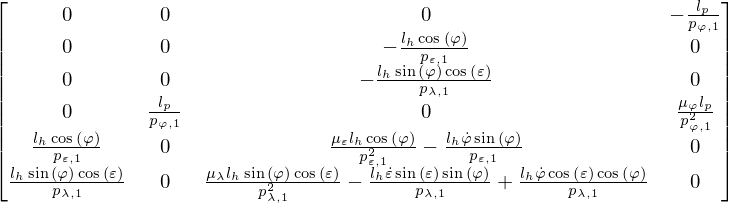

In [7]:
Gis[1]

In [8]:
sb.involutivity_test(Gis[1], x)

(False, (0, 2))

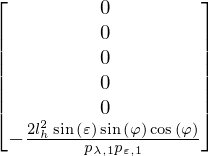

---


---


---


In [10]:
col1 = sb.col_select(Gis[1], 0)
col2 = sb.col_select(Gis[1], 2)
col_bracket = sb.lie_bracket(col1, col2, x) ##:

rank_G1 = sb.generic_rank(Gis[1]) ##:
G1_and_bracket = sb.concat_cols(Gis[1], col_bracket)
rank_G1_and_bracket = sb.generic_rank(G1_and_bracket) ##:

In [10]:
h1 = eps
h2 = lamb
h = sp.Matrix([h1, h2])

In [11]:
def vec_rel_degree(f, g, h, x):
    m = h.rows # == g.cols
    
    r = [1 for _ in range(m)]
    
    for i in range(m):
        input_occurred = False
        
        while not input_occurred:
            for j in range(g.cols):
                gj = sb.col_select(g, j)
                
                lie_deriv = sb.lie_deriv(sb.lie_deriv(h[i], f, x, order=r[i]-1), gj, x)
                
                if lie_deriv != 0:
                    input_occurred = True
            
            if not input_occurred:
                if r[i] < 10:
                    r[i] += 1
                else:
                    input_occurred = True
                    print(f"Warning: relative degree for output {i+1} either undefined or higher than 10. Aborting computation.")
    
    return r

def decoupling_matrix(f, g, h, r, x):
    return sp.Matrix([[sb.lie_deriv(sb.lie_deriv(h[i], f, x, order=r[i]-1), sb.col_select(g, j), x) for j in range(g.cols)] for i in range(h.rows)])

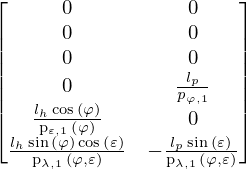

---


---


In [19]:
gx = sb.concat_cols(g1, g2) ##:
r = vec_rel_degree(f, gx, h, x) ##:

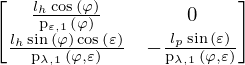

---


In [20]:
decoupling_matrix(f, gx, h, r, x) ##:

Dynamic Extension

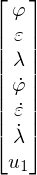

---


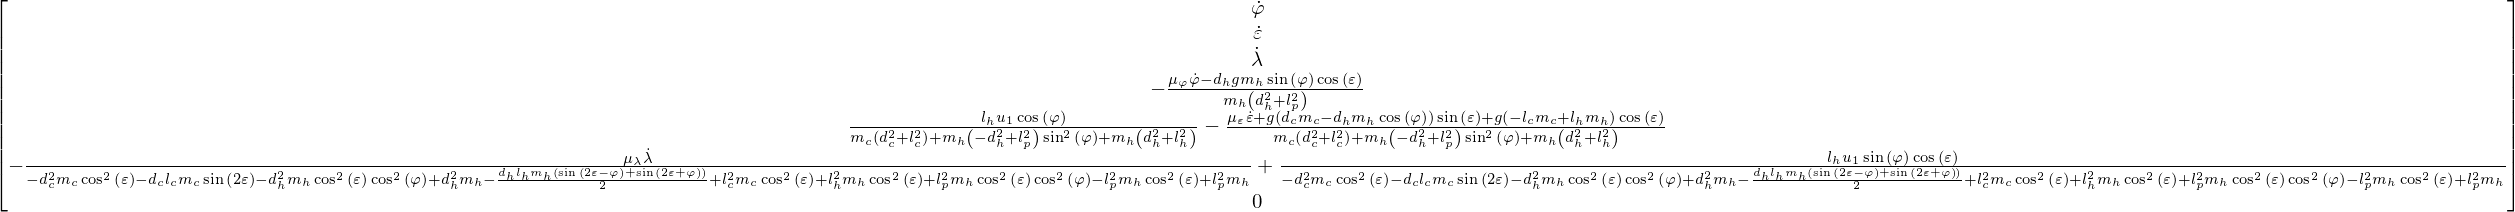

---


---


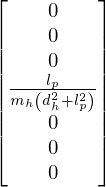

---


In [52]:
u1 = sp.Symbol('u_1')  # new state
x_ext1 = sb.concat_rows(x, u1) ##:
f_ext1 = sb.concat_rows(f + g1*u1, sp.S(0)) ##:
g1_ext1 = sp.Matrix([0, 0, 0, 0, 0, 0, 1]) ##:
g2_ext1 = sb.concat_rows(g2, sp.S(0)) ##:

---


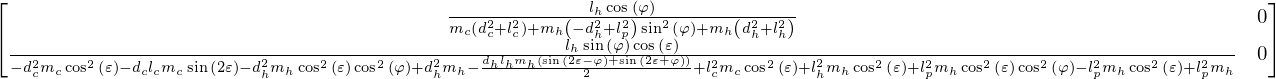

---


In [19]:
gx_ext1 = sb.concat_cols(g1_ext1, g2_ext1)
r_ext1 = vec_rel_degree(f_ext1, gx_ext1, h, x_ext1) ##:
decoupling_matrix_ext1 = decoupling_matrix(f_ext1, gx_ext1, h, r_ext1, x_ext1) ##:

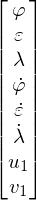

---


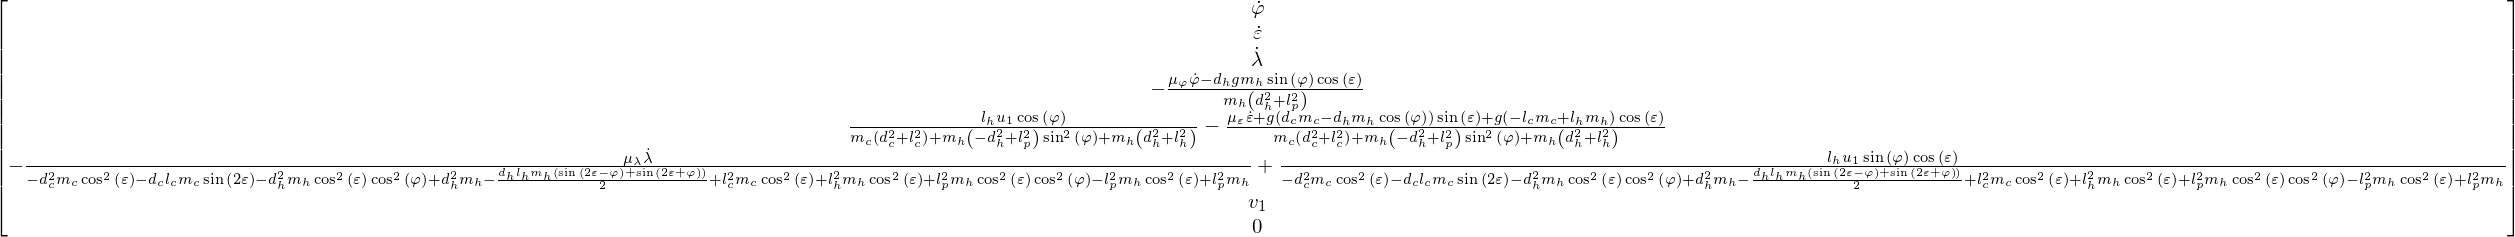

---


---


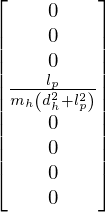

---


In [53]:
v1 = sp.Symbol('v_1')  # new state
x_ext2 = sb.concat_rows(x_ext1, v1) ##:
f_ext2 = sb.concat_rows(f_ext1 + g1_ext1*v1, sp.S(0)) ##:
g1_ext2 = sp.Matrix([0, 0, 0, 0, 0, 0, 0, 1]) ##:
g2_ext2 = sb.concat_rows(g2_ext1, sp.S(0)) ##:

---


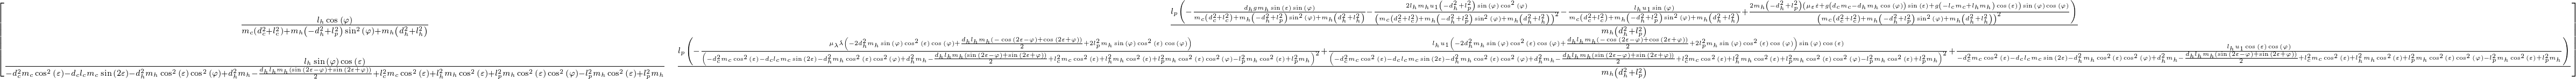

---


In [58]:
gx_ext2 = sb.concat_cols(g1_ext2, g2_ext2)
r_ext2 = vec_rel_degree(f_ext2, gx_ext2, h, x_ext2) ##:
decoupling_matrix_ext2 = decoupling_matrix(f_ext2, gx_ext2, h, r_ext2, x_ext2) ##:

In [33]:
sb.generic_rank(decoupling_matrix_ext2)

### AD verification

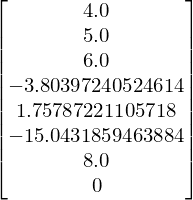

---


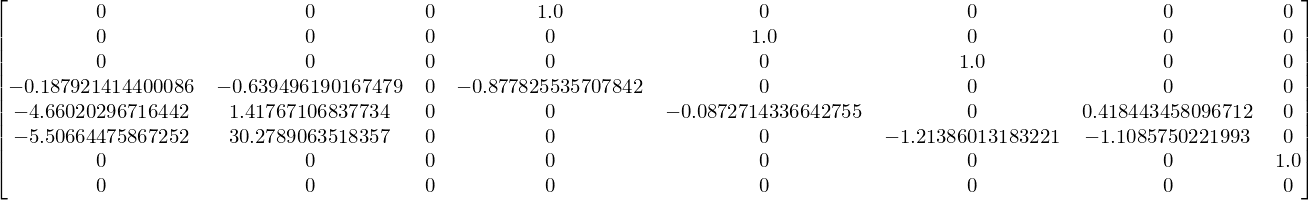

---


In [11]:
param_symbols = [g, lh, lp, lc, dh, dc, mc, mh, mup, mue, mul]
param_values = [9.81, 0.67, 0.178, 0.4069, 0.0027, 0.0639, 1.7638, 1.2006, 0.0334, 0.0755, 0.2569]
param_subs = list(zip(param_symbols, param_values))

x_subs = list(zip(x_ext2, [i+1 for i in range(10)]))
f_eval = sp.N(f_ext2.subs(param_subs).subs(x_subs)) ##:
f_jac_eval = sp.N(f_ext2.jacobian(x_ext2).subs(param_subs).subs(x_subs)) ##:

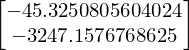

---


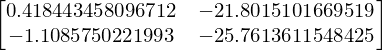

---


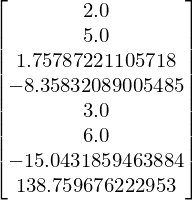

---


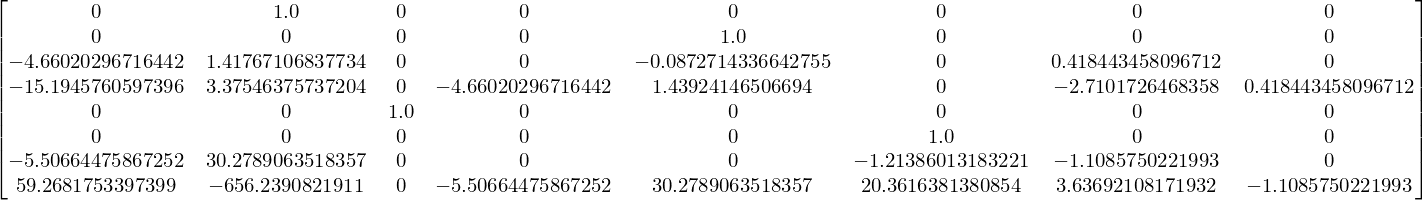

---


In [60]:
gamma_eval = sp.N(sp.Matrix([sb.lie_deriv(h1, f_ext2.subs(param_subs), x_ext2, order=4), sb.lie_deriv(h2, f_ext2.subs(param_subs), x_ext2, order=4)]).subs(x_subs)) ##:
decoupling_eval = sp.N(decoupling_matrix(f_ext2.subs(param_subs), gx_ext2.subs(param_subs), h, [4, 4], x_ext2).subs(x_subs)) ##:
phi = sp.Matrix([sb.lie_deriv(h1, f_ext2.subs(param_subs), x_ext2, order=i) for i in range(4)]+[sb.lie_deriv(h2, f_ext2.subs(param_subs), x_ext2, order=i) for i in range(4)])
phi_eval = sp.N(phi.subs(x_subs)) ##:
phi_jacobian_eval = sp.N(phi.jacobian(x_ext2).subs(x_subs)) ##:

### High-Gain observer analysis

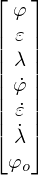

---


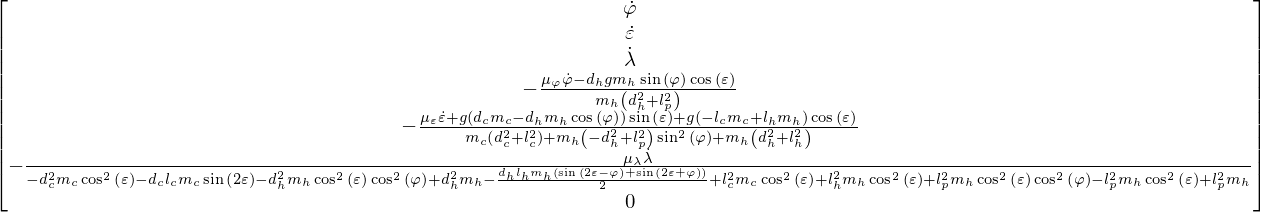

---


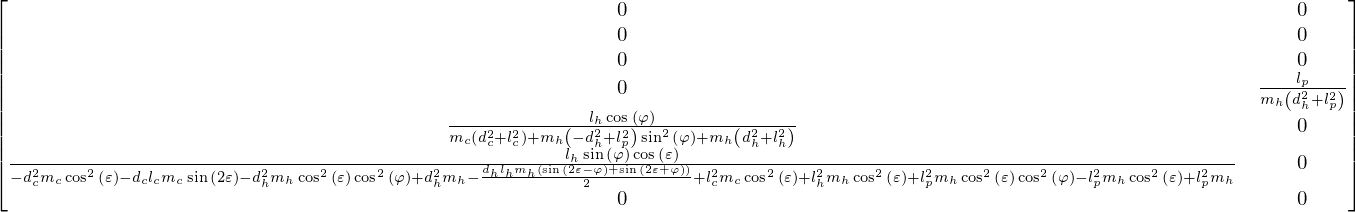

---


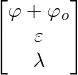

---


In [16]:
phi_o = sp.Symbol('varphi_o')
x_obs = sb.row_stack(x, phi_o) ##:
f_obs = sb.row_stack(f, sp.S(0)) ##:
g_obs = sb.col_stack(sb.row_stack(g1, sp.S(0)), sb.row_stack(g2, sp.S(0))) ##:
h_obs = sp.Matrix([phi + phi_o, eps, lamb]) ##:

In [20]:
def lie_deriv(h, *args, **kwargs):
    if isinstance(h, sp.Matrix):
        return sp.Matrix([sb.lie_deriv(hi, *args, **kwargs) for hi in h])
    else:
        return sb.lie_deriv(h, *args, **kwargs)

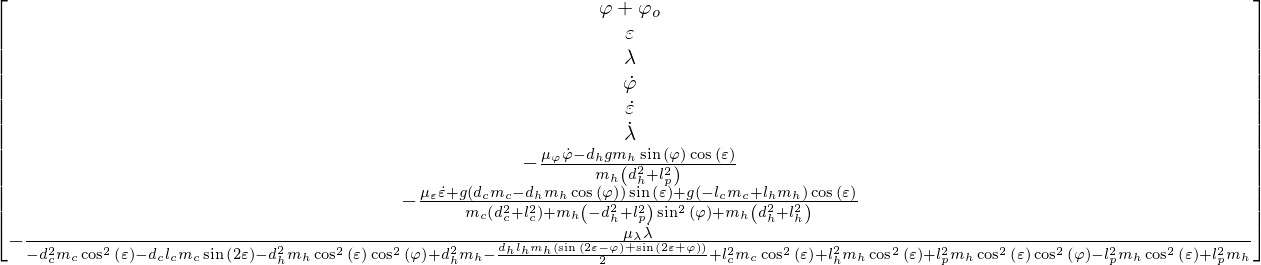

---


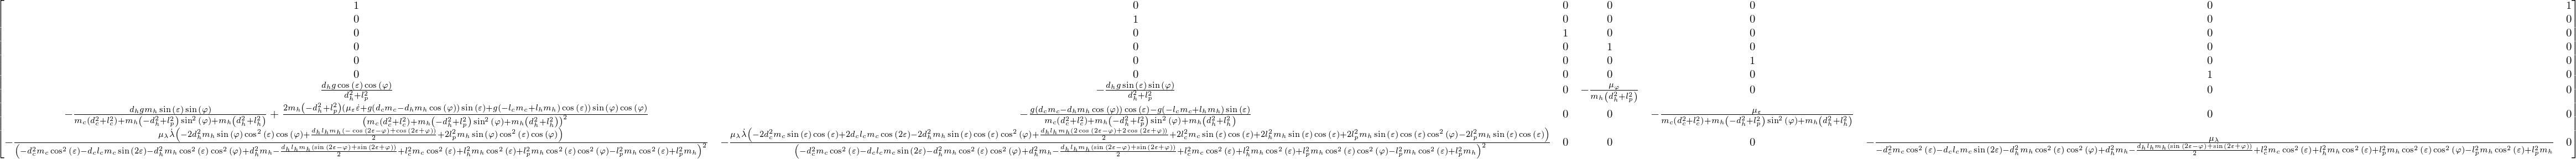

---


---


In [30]:
qB = sb.row_stack(*[lie_deriv(h_obs, f_obs, x_obs, order=i) for i in range(3)]) ##:
QB = qB.jacobian(x_obs) ##:
QB_rank = sb.generic_rank(QB) ##:

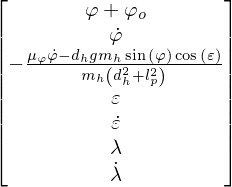

---


---


In [50]:
qA = sb.row_col_select(qB, [0, 3, 6, 1, 4, 2, 5], [0]) ##:
QA = qA.jacobian(x_obs)
QA_rank = sb.generic_rank(QA) ##:

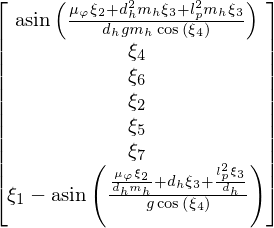

---


In [61]:
xi_obs = sb.symb_vector('xi1:8')
qA_inv = sp.Matrix(sp.solve(qA - xi_obs, x_obs)[1]) ##:

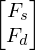

---


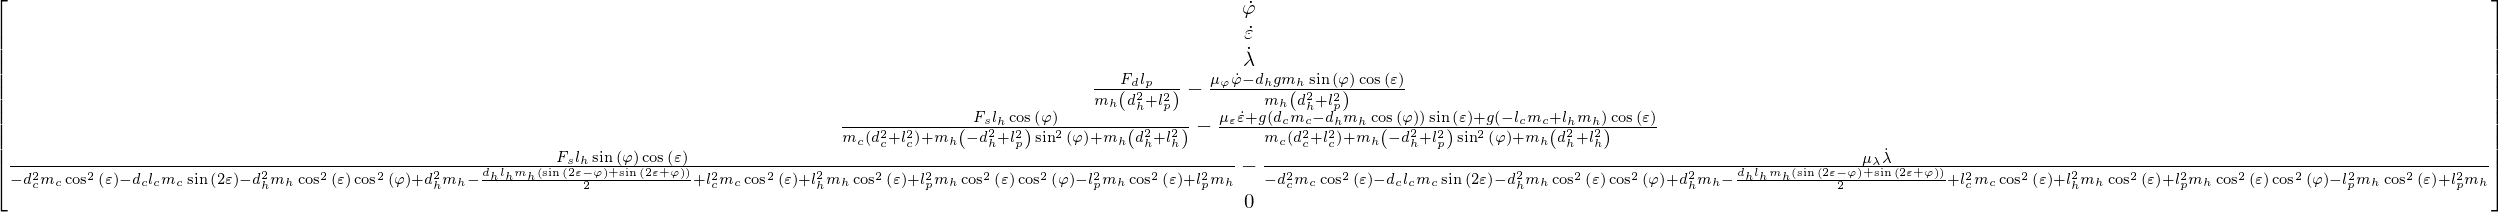

---


In [64]:
u = sb.symb_vector('F_s F_d') ##:
dx_obs = f_obs + g_obs * u ##:

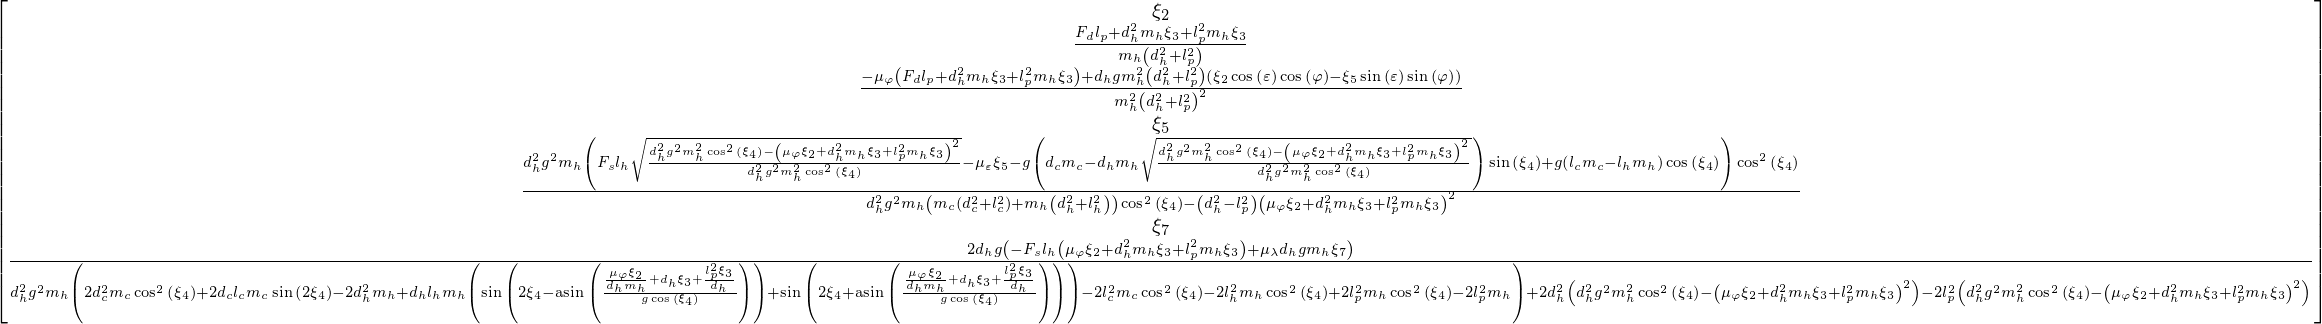

---


In [67]:
dxi_obs = sp.simplify(QA * dx_obs.subz(x_obs, qA_inv)) ##: